In [2]:
import pandas as pd
import os

plot_directory = '../images/'

os.makedirs(plot_directory, exist_ok=True)


# Step 1 - Data Extraction/Collection

In [3]:
# ETL Process

# Extract - Step 1
df = pd.read_csv('../data/customer_shopping_data.csv')


# Step 2 - Exploratory Data Analysis (EDA)

## Structure, Duplicates, and Null values

In [4]:
# EDA - Step 2
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [5]:
df.info()

# Most are object dtype, must convert to appropriate types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [6]:
# Check for duplicates
df[['invoice_no','customer_id']].duplicated().sum()

# No duplicates

np.int64(0)

In [7]:
df[df[['invoice_no','customer_id']].duplicated()]

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall


In [8]:
# Check for null values
df.isnull().sum()

# No null values

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

## Basic visualizations

### Gender

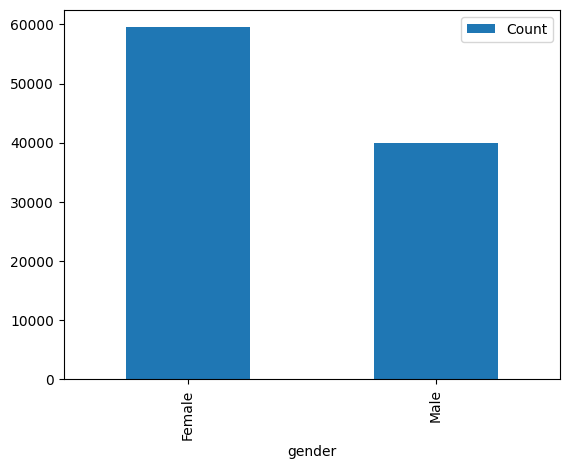

In [9]:
gender_group = df.groupby('gender')['customer_id'].count().reset_index(name='Count')

ax = gender_group.plot.bar(x='gender', y='Count')

fig = ax.figure

fig.savefig(os.path.join(plot_directory, 'raw_gender_distribution_barplot.png'))

# Output:
# F: 1
# M: 3
# Female: 7
# Male: 7

# Multiple types of only two genders are present, must standardize

### Age

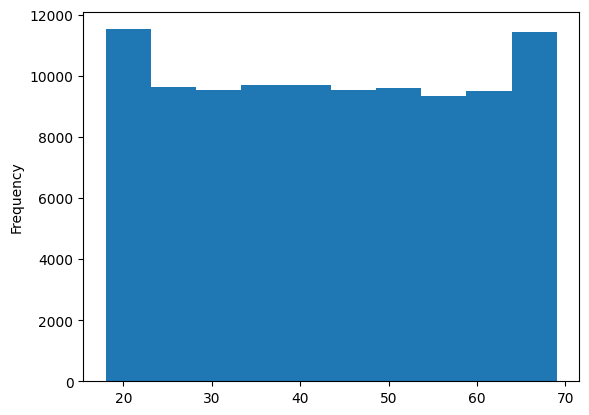

In [10]:
ax = df['age'].plot.hist(bins=10)
fig = ax.figure
fig.savefig(os.path.join(plot_directory, 'raw_age_distribution_histogram.png'))

### Category

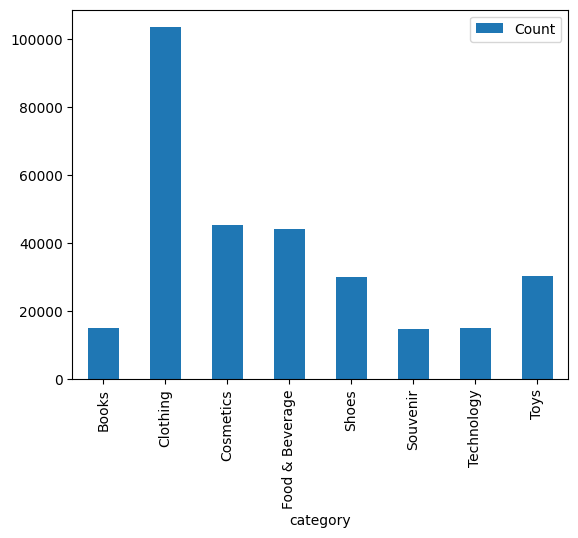

In [11]:
category_group = df.groupby('category')['quantity'].sum().reset_index(name='Count')

ax = category_group.plot.bar(x='category', y='Count')

fig = ax.figure

fig.savefig(os.path.join(plot_directory, 'raw_category_barplot.png'))

### Payment Method Used

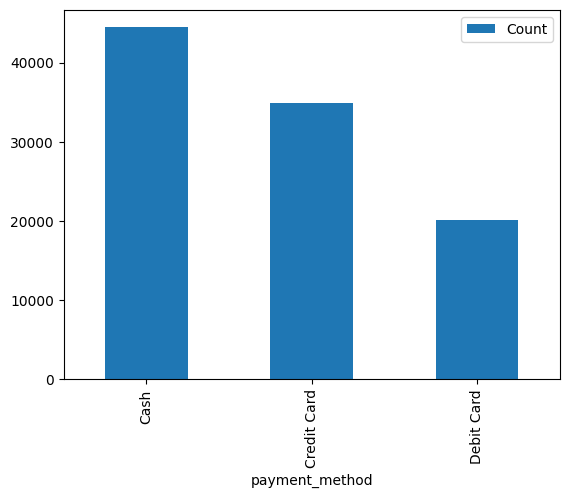

In [12]:
payment_group = df.groupby('payment_method')['customer_id'].count().reset_index(name='Count')
ax = payment_group.plot.bar(x='payment_method', y='Count')
fig = ax.figure
fig.savefig(os.path.join(plot_directory, 'raw_payment_method_barplot.png'))

### Dates

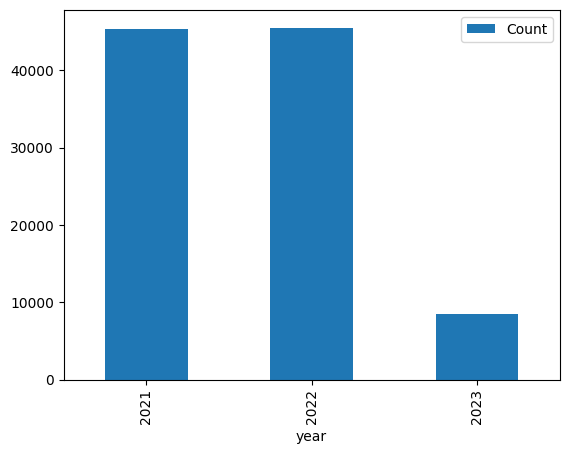

In [13]:
# Number of transactions by year
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='mixed', dayfirst=True)
df['year'] = df['invoice_date'].dt.year
year_group = df.groupby('year')['customer_id'].count().reset_index(name='Count')
ax = year_group.plot.bar(x='year', y='Count')
fig = ax.figure
fig.savefig(os.path.join(plot_directory, 'raw_transactions_by_year_barplot.png'))

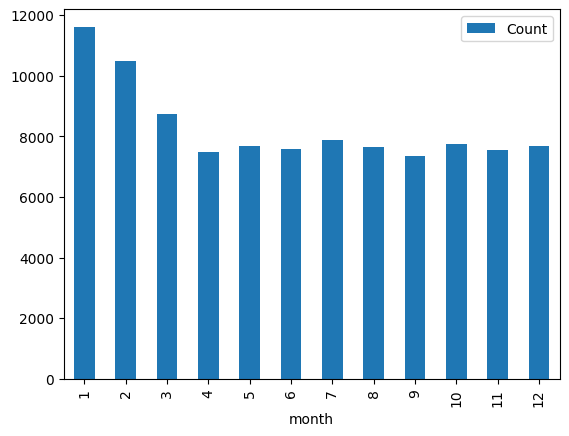

In [14]:
# Number of transactions by month
df['month'] = df['invoice_date'].dt.month
month_group = df.groupby('month')['customer_id'].count().reset_index(name='Count')
ax = month_group.plot.bar(x='month', y='Count')
fig = ax.figure
fig.savefig(os.path.join(plot_directory, 'raw_transactions_by_month_barplot.png'))

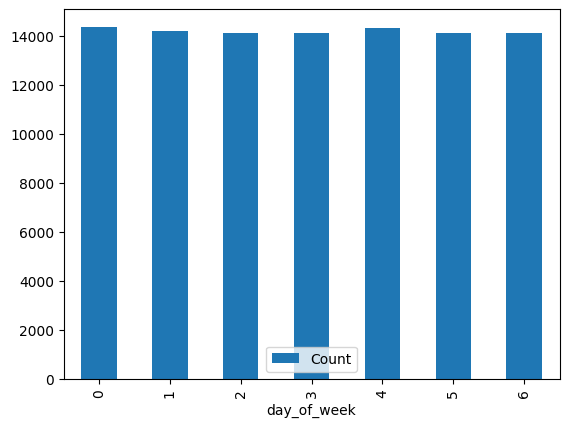

In [15]:
# Number of transactions by day of week
df['day_of_week'] = df['invoice_date'].dt.dayofweek
day_group = df.groupby('day_of_week')['customer_id'].count().reset_index(name='Count')
ax = day_group.plot.bar(x='day_of_week', y='Count')
fig = ax.figure
fig.savefig(os.path.join(plot_directory, 'raw_transactions_by_day_of_week_barplot.png'))

### Shopping Mall

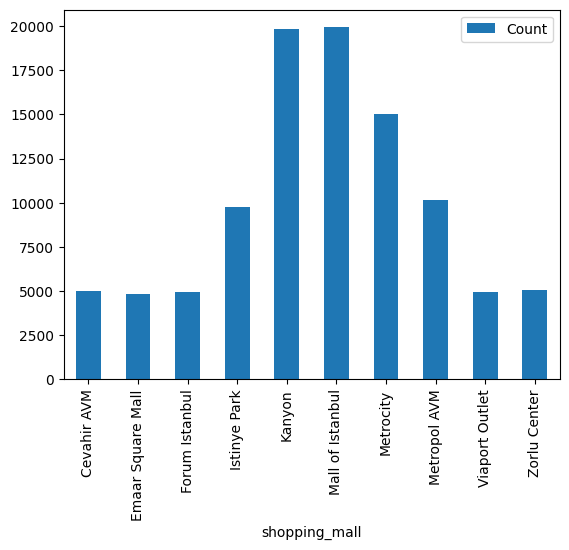

In [16]:
mall_group = df.groupby('shopping_mall')['customer_id'].count().reset_index(name='Count')
ax = mall_group.plot.bar(x='shopping_mall', y='Count')
fig = ax.figure
fig.savefig(os.path.join(plot_directory, 'raw_transactions_by_shopping_mall_barplot.png'))

Data does not seem to contain any inconsistencies. Proceed to loading into a PostgreSQL database

# Step 3 - Data Cleaning

## Gender Standardization

In [18]:
df['gender'] = df['gender'].replace({'Male': 'M', 'Female': 'F'})

## Convert into proper data types

In [20]:
# Convert pandas dtypes to native Python types for psycopg2 compatibility
# psycopg2 does not support pandas dtypes directly
df = df.astype({
    'invoice_no': 'str',
    'customer_id': 'str',
    'gender': 'str',
    'age': 'int',
    'category': 'str',
    'quantity': 'int',
    'price': 'float',
    'payment_method': 'str',
    'invoice_date': 'datetime64[ns]',
    'shopping_mall': 'str',
    'year': 'int',
    'month': 'int',
    'day_of_week': 'int'
})

In [21]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month,day_of_week
0,I138884,C241288,F,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,2022,8,4
1,I317333,C111565,M,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12,6
2,I127801,C266599,M,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,2021,11,1
3,I173702,C988172,F,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,5,6
4,I337046,C189076,F,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,10,6


# Step 4 - Data Load/Store

In [22]:
# Load - Step 4

# Database connection parameters
from configparser import ConfigParser

config = ConfigParser()
config.read('../config.ini')

hostname = config.get('DATABASE', 'hostname')
database = config.get('DATABASE', 'database')
port = config.get('DATABASE', 'port')
username = config.get('DATABASE', 'username')
password = config.get('DATABASE', 'password')


In [23]:
import psycopg2

In [ ]:
conn = None
cur = None

# Connect to PostgreSQL database
try:
    conn = psycopg2.connect(
        host = hostname,
        database = database,
        user = username,
        password = password,
        port = port
    )
    cur = conn.cursor()

    cur.execute('DROP TABLE IF EXISTS customers;')

    create_table_query = '''
    CREATE TABLE IF NOT EXISTS customers (
        invoice_no VARCHAR(20) PRIMARY KEY,
        customer_id VARCHAR(20),
        gender CHAR(10),
        age INT,
        category VARCHAR(50),
        quantity INT,
        price FLOAT,
        payment_method VARCHAR(50),
        invoice_date TIMESTAMP,
        shopping_mall VARCHAR(50),
        year INT,
        month INT,
        day_of_week INT
    );
    '''
    cur.execute(create_table_query)

    insert_query = '''
    INSERT INTO customers (invoice_no, customer_id, gender, age, category, quantity, price, payment_method, invoice_date, shopping_mall, year, month, day_of_week)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    '''

    # Convert DataFrame to list of tuples
    insert_values = list(df.itertuples(index=False, name=None))

    for record in insert_values:
        cur.execute(insert_query, record)

    conn.commit()

except Exception as error:
    print(f"Error: {error}")
except psycopg2.Error as db_error:
    print(f"Database error: {db_error}")
finally:
    if cur:
        cur.close()
    if conn:
        conn.close()